In [23]:
import numpy as np
from scipy.fft import fft, ifft, rfft, irfft, fftfreq
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from matplotlib import rcParams
import matplotlib.animation as animation

import sys
sys.path.append('..')
import QLCstuff as QLC
import f90nml

In [24]:
%matplotlib inline
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
color = 'k'
markersize = 10

In [25]:
inputfile = "GI parameters - Reference limit cycle copy.nml"

In [26]:
# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Diffusion coeficient
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

Using parameter file GI parameters - Reference limit cycle copy.nml ...

From the GrowthInstability (GI) namelist:
D = 0.000365 micrometer ** 2 / microsecond
L = 30 micrometer
nx (crystal) = 50
odemethod = RK45


In [27]:
# Conversions (in case inputs are in other units)
D.ito('micrometer^2/microsecond')
L.ito('micrometer')

In [28]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
DoverdeltaX2 = D/deltax**2
print(deltax ** 2)

Spacing of points on the ice surface = 1.224489795918366 micrometer
1.4993752603082018 micrometer ** 2


In [29]:
def diffusion_term_cart(NQLL0, DoverdeltaX2):
    dy = np.empty(np.shape(NQLL0))
    for i in range(1,len(NQLL0)-1):
        dy[i] = DoverdeltaX2*(NQLL0[i-1]-2*NQLL0[i]+NQLL0[i+1])
    dy[0]  = DoverdeltaX2*(NQLL0[-1] -2*NQLL0[0] +NQLL0[1]) # Periodic BC
    dy[-1] = DoverdeltaX2*(NQLL0[-2] -2*NQLL0[-1]+NQLL0[0])
    
    return dy

C:\Users\spenc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook\__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


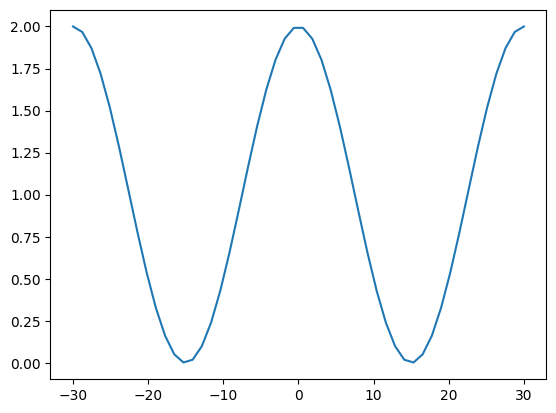

In [30]:
NQLL0 = np.cos(x_QLC * 2 * np.pi / L) + 1
plt.figure()
plt.plot(x_QLC.magnitude, NQLL0)

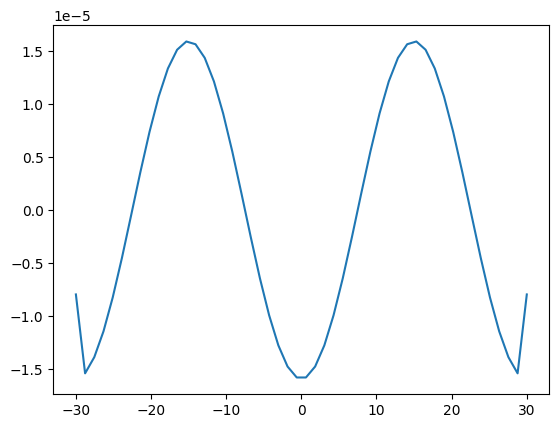

In [31]:
test = diffusion_term_cart(NQLL0, DoverdeltaX2.magnitude)
plt.figure()
plt.plot(x_QLC.magnitude, test)

In [32]:
#test diffusion term function

"""
test_analytical = - (2 * np.pi / L)**2 * D * np.cos(x_QLC * 2 * np.pi / L)
plt.figure()
plt.plot(x_QLC.magnitude, test_analytical)
"""

'\ntest_analytical = - (2 * np.pi / L)**2 * D * np.cos(x_QLC * 2 * np.pi / L)\nplt.figure()\nplt.plot(x_QLC.magnitude, test_analytical)\n'

In [33]:
dt = deltax ** 2 / D / 3
print(dt)

t_max = AssignQuantity(500, 'milliseconds')

n_t = int(t_max / dt)
print(n_t)

1369.2924751673074 microsecond
365


In [34]:
NQLL = np.copy(NQLL0)
for i in range(n_t):
    term_1 = dt.magnitude * diffusion_term_cart(NQLL, DoverdeltaX2.magnitude)
    NQLL += term_1

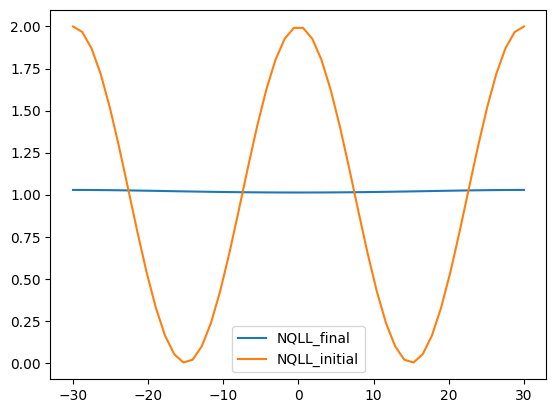

In [35]:
    
plt.figure()
plt.plot(x_QLC.magnitude, NQLL, label = 'NQLL_final')
plt.plot(x_QLC.magnitude, NQLL0, label = "NQLL_initial")
plt.legend()

In [36]:
bj_list = rfft(NQLL0)
j_list = np.array([j for j in range(len(bj_list))])
j2_list = np.array(j_list)**2
print(j_list)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


C:\Users\spenc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\fft\_pocketfft\helper.py:98: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(x, dtype=dtype, copy=copy)


In [37]:
# Diffusion term based on FT
def diffusion_term_FT(NQLL0, DoverdeltaX2):
    l = int(len(NQLL0)/2)
    Dcoefficient1 = DoverdeltaX2/l**2*np.pi**2; #print('Dcoefficient1', Dcoefficient1)
    bj_list = rfft(NQLL0)
    j_list = np.array([j for j in range(len(bj_list))])
    j2_list = np.array(j_list)**2
    cj_list = bj_list*j2_list
    dy = -Dcoefficient1  * irfft(cj_list)

    return dy

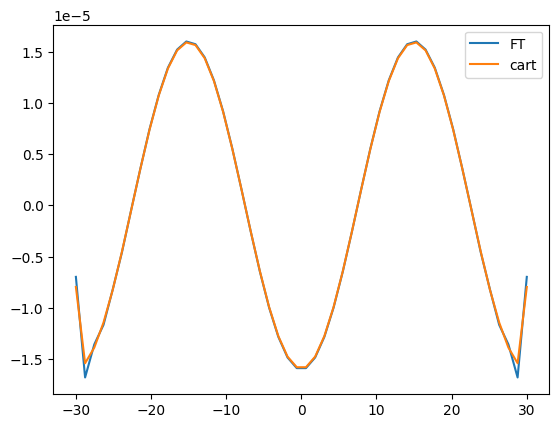

In [38]:
test_FT = diffusion_term_FT(NQLL0, DoverdeltaX2.magnitude)
plt.figure()
plt.plot(x_QLC.magnitude, test_FT, label = 'FT')
plt.plot(x_QLC.magnitude, test, label = 'cart')
plt.legend()

In [45]:
def diffusion_term_FT_b_list(bj_list, DoverdeltaX2):
    l = int(len(NQLL0)/2)
    Dcoefficient1 = DoverdeltaX2/l**2*np.pi**2; #print('Dcoefficient1', Dcoefficient1)
    j_list = np.array([j for j in range(len(bj_list))])
    j2_list = np.array(j_list)**2
    cj_list = bj_list*j2_list
    dy = -Dcoefficient1 * cj_list

    return dy

In [46]:
bj_list0 = rfft(NQLL0)
print(bj_list0)

[ 5.10000000e+01+0.00000000e+00j  1.31250622e+00+8.25758920e-02j
  2.49875329e+01+3.15665951e+00j -8.41102535e-01-1.60448890e-01j
 -3.37213388e-01-8.65816822e-02j -1.86899625e-01-6.07273693e-02j
 -1.18631832e-01-4.69696649e-02j -8.11714222e-02-3.81963719e-02j
 -5.82075817e-02-3.19998889e-02j -4.30553704e-02-2.73237689e-02j
 -3.25178637e-02-2.36256109e-02j -2.48960084e-02-2.05957693e-02j
 -1.92142303e-02-1.80433632e-02j -1.48781669e-02-1.58436385e-02j
 -1.15083371e-02-1.39111899e-02j -8.85312383e-03-1.21852796e-02j
 -6.74047640e-03-1.06212913e-02j -5.04977364e-03-9.18550415e-03j
 -3.69475876e-03-7.85176204e-03j -2.61283645e-03-6.59927157e-03j
 -1.75817251e-03-5.41109859e-03j -1.09714786e-03-4.27310878e-03j
 -6.05319786e-04-3.17319744e-03j -2.65381394e-04-2.10071004e-03j
 -6.58080317e-05-1.04598871e-03j  0.00000000e+00+0.00000000e+00j]


In [47]:
bj_list = np.copy(bj_list0)
for i in range(n_t):
    term_1 = dt.magnitude * diffusion_term_FT_b_list(bj_list, DoverdeltaX2.magnitude)
    bj_list += term_1

C:\Users\spenc\AppData\Local\Temp\ipykernel_2612\357197385.py:6: RuntimeWarning: overflow encountered in multiply
  cj_list = bj_list*j2_list
C:\Users\spenc\AppData\Local\Temp\ipykernel_2612\357197385.py:7: RuntimeWarning: invalid value encountered in multiply
  dy = -Dcoefficient1 * cj_list
C:\Users\spenc\AppData\Local\Temp\ipykernel_2612\3158804987.py:3: RuntimeWarning: invalid value encountered in multiply
  term_1 = dt.magnitude * diffusion_term_FT_b_list(bj_list, DoverdeltaX2.magnitude)


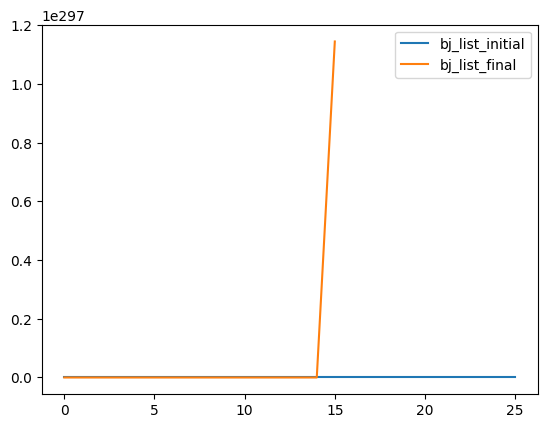

In [49]:
j_list = np.array([j for j in range(len(bj_list))])

plt.figure()
plt.plot(j_list, bj_list0, label = 'bj_list_initial')
plt.plot(j_list, bj_list, label = "bj_list_final")
plt.legend()

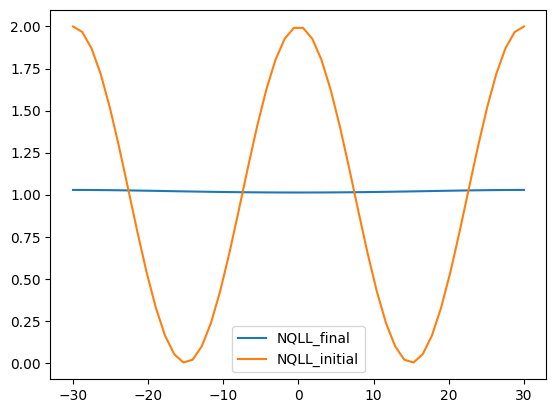

In [43]:
plt.figure()
plt.plot(x_QLC.magnitude, NQLL, label = 'NQLL_final')
plt.plot(x_QLC.magnitude, NQLL0, label = "NQLL_initial")
plt.legend()